# Solutions: MLBD final exam (Spring 2022)

The exam questions are contained in this Jupyter Notebook. The `data` folder contains the data. 

The logistical details, rules, and guidelines pertaining to the exam are stated below.   

### Timeline and Submission
**Exam date:** July 6, 2022   
**Exam start:** 15h15  
**Exam end:** 18h15

### Instructions
This exam consists of two parts, a Moodle quiz with conceptual questions and programming exercises in this notebook. **Note that the Moodle quiz with the conceptual questions will be closed by 16h15, therefore please make sure to answer the conceptual questions within the first hour of the exam. To submit this notebook for the coding questions, you should upload it to Moodle (at the latest by 18h15).**

In case of issues with Moodle, send your file named as "SCIPER_Firstname_Lastname.ipynb" via email to paola.mejia@epfl.ch, subject "[MLBD] Exam notebook".

### Rules

1. You are allowed to use any environment. We recommend using EPFL's Noto environment, accessible through the link: [https://noto.epfl.ch/](https://noto.epfl.ch/). We prepared a Python environment with all the Python packages that you might need for the exam, in the default EPFL's Noto installation. If you want to use some additional packages, feel free to install and use them in a virtual environment. In this case, it is your own responsibility to make sure that your environment is functional and that your results can be properly interpreted for grading. 


2. Please write all your comments in English, and use meaningful variable names in your code.

3. When asked for plots, please include all the needed decorations: namely title, x/y-axis labels, appropriate x/y-ticks, legend, and so on. 

4. We will grade your notebook as is, which means that only the results showed in your evaluated code cells will be considered. Please be sure to submit a **fully-run and evaluated notebook**. We will not run the notebook for you. Interactive plots, such as those generated using `plotly`, should be **strictly avoided**.

5. You can use all the online resources (including the code from the demo notebooks from the course) you want except for communication tools (emails, web chats, forums, phone, etc.). Remember, this is not a project assignment. Therefore, no teamwork is allowed.

### Setup
We intend this notebook to be completed on EPFL's Noto environment. As in past lecture exercises, you will need to use the `Tensorflow` kernel for the dependencies to be installed appropriately. Change the kernel in the upper right corner of Noto. Select `Tensorflow`.


In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import tensorflow as tf
import seaborn as sns
from scipy import linalg

from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import adjusted_mutual_info_score
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel, mutual_info_classif
from sklearn import model_selection
from sklearn.metrics import roc_auc_score, balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay, silhouette_score
from sklearn.model_selection import train_test_split

from sklearn.neighbors import kneighbors_graph
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.manifold import spectral_embedding
from scipy.sparse.csgraph import laplacian
from sklearn.cluster import KMeans
from scipy.spatial.distance import pdist, squareform, cdist

## Question 1 (15 points)
You are the Senior Data Scientist in a learning platform called LernTime. You have realized that many users stop using the platform and want to increase user retention. For this purpose, you decide to build a model to predict whether a student will stop using the learning platform or not.

Your data science team built a data frame in which each row contains the aggregated features per student (calculated over the first 5 weeks of interactions) and the feature `dropout` indicates whether the student stopped using the platform (1) or not (0) before week 10.

The dataframe is in the file `lerntime.csv` and contains the following features:
- `video_time`: total video time (in minutes) 
- `num_sessions` total number of sessions
- `num_quizzes`: total number of quizzes attempts
- `reading_time`: total theory reading time
- `previous_knowledge`: standardized previous knowledge
- `browser_speed`: standardized browser speed
- `device`:  whether the student logged in using a smartphone (1) or a computer (-1)
- `topics`: the topics covered by the user
- `education`: current level of education (0: middle school, 1: high school, 2: bachelor, 3: master, 4: Ph.D.).
- `dropout`: whether the student stopped using the platform (1) or not (0) before week 5.

The newest data scientist created two models with an excellent performance. As a Senior Data Scientist, you are suspicious of the results and decide to revise the code. 

Your task is to:

a) Identify the mistakes. In the first cell, add a comment above each line in which you identify an error and explain the error.

b) In the second cell, you must correct the code.

In [8]:
df = pd.read_csv('data/lerntime_dropout.csv')

y = df['dropout']
X = df[['video_time', 'num_sessions', 'num_quizzes', 'reading_time',
       'previous_knowledge', 'browser_speed']]

### a) Identify the mistakes in the code (10 points)
In the following cell, add a comment above each line in which you identify an error and explain the why it is erroneous.
Please start each of your comments with `#ERROR:`. For example:

`#ERROR: the RMSE of the model is printed instead of the AUC`

`print("The AUC of the model is: {}".format(rmse))          `

You may assume that: 
- all the features are continous and numerical. 
- the features have already been cleaned and processed. 

In [9]:
# ERROR: Train-test split should be done before preprocessing steps 1. and 2. to avoid data leakage, 
# fitting both scaler and selector only on X_train
## 1. Scale the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

## 2. Feature selection (Lasso)
print(X.shape)
lasso = Lasso(alpha=0.1, random_state=0).fit(X, y)
selector = SelectFromModel(lasso, prefit = True)
X = selector.transform(X)
print(X.shape)

## 3. Split the data
# ERROR: Splitting should be stratified on y, since the dataset is unbalanced
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)

## Model 1
clf = RandomForestClassifier(n_estimators=10, max_depth=2, random_state=0)
# ERROR: Fit should only be called on the train set
clf.fit(X,y)
preds = clf.predict(X_test)
# ERROR: The adjusted mutual information is not an appropriate score for classification, since it would give
# a perfect score even if the predictions are the complete opposite of y_test
print("Score model 1: {}".format(np.round(adjusted_mutual_info_score(preds, y_test), 2)))

## Model 2
clf = RandomForestClassifier(n_estimators=1000, max_depth=None, random_state=0)
# ERROR: Fit should only be called on the train set
clf.fit(X,y)
preds = clf.predict(X_test)
# ERROR: The adjusted mutual information is not an appropriate score for classification, since it would give
# a perfect score even if the predictions are the complete opposite of y_test
print("Score model 2: {}".format(np.round(adjusted_mutual_info_score(preds, y_test), 2)))

# ERROR: The second model has just more complexity and can hence better overfit to the test set, which leaked during training
## Discussion
# Our second model achieved perfect results with unseen data and outperforms the first model.
## This is because we increased the number of estimators.

(300, 6)
(300, 3)
Score model 1: 0.31
Score model 2: 1.0


### b) Correct the code (5 points)
Correct all the erroneous code in the following cell.

In [10]:
## 1. Split the data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state=0)

## 2. Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## 3. Feature selection (Lasso)
print(X_train.shape)
lasso = Lasso(alpha=0.1, random_state=0).fit(X_train, y_train)
selector = SelectFromModel(lasso, prefit = True)
X_train = selector.transform(X_train)
X_test = selector.transform(X_test)
print(X_train.shape)

## Model 1
clf = RandomForestClassifier(n_estimators=10, max_depth=2, random_state=0)
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
print("Score model 1: {}".format(np.round(balanced_accuracy_score(preds, y_test), 2)))

## Model 2
clf = RandomForestClassifier(n_estimators=1000, max_depth=None, random_state=0)
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
print("Score model 2: {}".format(np.round(balanced_accuracy_score(preds, y_test), 2)))

## Discussion
# Our first model achieved good results with unseen data, outperforming the second model.
# This might be because, without limiting the depth of each tree, the second model is overfitting more to the training set.

(240, 3)
(240, 3)
Score model 1: 0.74
Score model 2: 0.81


# Question 2 (5 points)
You decide to explore the data further. You are especially interested in the two features `device` and `education` and decide to explore the relationship between them.  

What is the relationship between the two features `device` and `education`? Support your answer with informative metrics. 

In [11]:
df.device.value_counts()

1.0    268
0.0     32
Name: device, dtype: int64

In [12]:
df.groupby('education').device.value_counts(normalize=True)

education  device
0.0        0.0       1.0
1.0        1.0       1.0
2.0        1.0       1.0
3.0        1.0       1.0
4.0        1.0       1.0
Name: device, dtype: float64

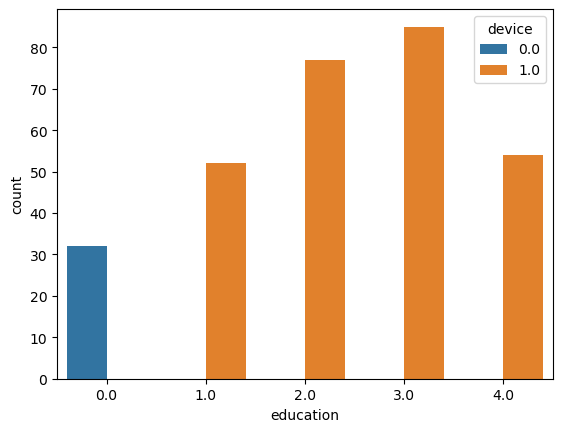

In [13]:
sns.countplot(x='education', hue='device', data=df)
plt.show()

In [19]:
df.education.values.shape

(300,)

In [20]:
df.device.values.shape

(300,)

In [23]:
mutual_info_classif(df.education.values.reshape(-1, 1), df.device.values, discrete_features=True)

array([0.33948894])

It seems that users with higher education tend to use computers instead of smartphones, possibly indicating a more serious/dedicated approach to learning with respect to middle and high school students for which browsing the platform is more of a casual activity. This interpretation is coherent with the mutual information computed between the two features (~0.34), which indicates a relevant correlation between them. In fact, if we have information about the device, we can make a better prediction for education, and viceversa.

# Question 3 (40 points)

After having looked in more detail into the features, you decide to explore the different type of users. You want to use your knowledge from your ML4BD course and decide to cluster using Spectral Clustering. In the course, you learnt different ways of constructing the similarity graph, yielding the adjacency matrix serving as an input to the Spectral Clustering. Based on your in-depth exploration of the data, you decide to construct the similarity graph as a  *k-nearest neighbor graph*.

Your tasks are to:

a) Write a function to compute the k-nearest neighbor graph.

b) Cluster the users using Spectral Clustering and your k-nearest neighbor graph function (use 4 neighbors). Use only the features *reading_time* and *topics*. You can assume that optimal number of clusters is 2.

c) Discuss the fairness of the obtained cluster solution regarding the level of education ('education')

## a) Computation of the k-nearest neighbor graph (17 points)
Unfortunately, there is no k-nearest neighbor graph implementation available in scikit-learn and you therefore have to implement the function yourself. The function `'k_nearest_neighbor_graph'` takes a similarity matrix `S` as well as the number of neighbors `k` as an input an returns the adjacency matrix `W`.

Note that we will not evaluate the coding efficiency of your function. 

In [40]:
import numpy as np


def my_k_nearest_neighbor_graph(S, k):
    # Connect node x to node y if x is among the k nearest neighbors of y or vice versa
    # Connection strength is the similarity between x and y, i.e. S[x,y]
    # S: similarity matrix
    # k: number of nearest neighbors
    # return: adjacency matrix
    S = np.array(S)
    A = np.zeros(S.shape)
    for i in range(S.shape[0]):
        top_k = np.argsort(S[i, :])[-(k+1):]
        A[i, top_k] = S[i, top_k]
        A[top_k, i] = S[top_k, i]
    return A


In [41]:
def k_nearest_neighbor_graph(S, k):
    # S: similarity matrix
    # k: number of neighbors
   
    S = np.array(S)
    # k+1 because include_self. -S to pass from similarity to distance, +translation to avoid negative values
    G = kneighbors_graph(-S + S.max(), k+1, metric='precomputed', mode='connectivity', include_self=True).toarray()
    W = (G + G.T).astype(bool) * S
    
    return W

In [42]:
k = 2
# Please run this cell for evaluation purposes
S = [[1, 1, 1, 1],
     [0.2, 1, 0.8, 0.4],
     [0.7, 0.8, 1, 0.6],
     [0.1, 0.4, 0.6, 1]]

print(k_nearest_neighbor_graph(S, k))
print(my_k_nearest_neighbor_graph(S, k))

[[1.  1.  1.  0. ]
 [0.2 1.  0.8 0.4]
 [0.7 0.8 1.  0.6]
 [0.  0.4 0.6 1. ]]
[[0.  1.  1.  1. ]
 [0.2 1.  0.8 0.4]
 [0.7 0.8 1.  0.6]
 [0.1 0.4 0.6 1. ]]


In [43]:
k = 2
# Please run this cell for evaluation purposes
S = [[1, 0.2, 0.7, 0.1],
     [0.2, 1, 0.8, 0.4],
     [0.7, 0.8, 1, 0.6],
     [0.1, 0.4, 0.6, 1]]

print(k_nearest_neighbor_graph(S, k))
print(my_k_nearest_neighbor_graph(S, k))

[[1.  0.2 0.7 0. ]
 [0.2 1.  0.8 0.4]
 [0.7 0.8 1.  0.6]
 [0.  0.4 0.6 1. ]]
[[1.  0.2 0.7 0. ]
 [0.2 1.  0.8 0.4]
 [0.7 0.8 1.  0.6]
 [0.  0.4 0.6 1. ]]


In [44]:
# Please run this cell for evaluation purposes
S = [[1, 0.3, 0.01, 0.1],
     [0.3, 1, 0.8, 0.9],
     [0.01, 0.8, 1, 0.6],
     [0.1, 0.9, 0.6, 1]]

print(k_nearest_neighbor_graph(S, k))
print(my_k_nearest_neighbor_graph(S, k))

[[1.  0.3 0.  0.1]
 [0.3 1.  0.8 0.9]
 [0.  0.8 1.  0.6]
 [0.1 0.9 0.6 1. ]]
[[1.  0.3 0.  0.1]
 [0.3 1.  0.8 0.9]
 [0.  0.8 1.  0.6]
 [0.1 0.9 0.6 1. ]]


## b) Spectral Clustering (15 points)
Perform a spectral clustering using a k-nearest neighbor graph (with 4 neighbors). Use the two features `reading_time` and `topics` only. If you did not manage to solve task 3a), use a *fully connected graph* as similarity graph to obtain the adjacency matrix `W`. You can assume that the optimal number of clusters is 2. Print the obtained cluster labels. 

In [45]:
# Function for doing spectral clustering
def spectral_clustering(W, n_clusters, random_state=111):
    """
    Spectral clustering
    :param W: np array of adjacency matrix
    :param n_clusters: number of clusters
    :param normed: normalized or unnormalized Laplacian
    :return: tuple (kmeans, proj_X, eigenvals_sorted)
        WHERE
        kmeans scikit learn clustering object
        proj_X is np array of transformed data points
        eigenvals_sorted is np array with ordered eigenvalues 
        
    """
    # Compute eigengap heuristic
    L = laplacian(W, normed=True)
    eigenvals, _ = linalg.eig(L)
    eigenvals = np.real(eigenvals)
    eigenvals_sorted = eigenvals[np.argsort(eigenvals)]

    # Create embedding
    random_state = np.random.RandomState(random_state)
    proj_X = spectral_embedding(W, n_components=n_clusters,
                              random_state=random_state,
                              drop_first=False)

    # Cluster the points using k-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state = random_state)
    kmeans.fit(proj_X)

    return kmeans, proj_X, eigenvals_sorted

In [52]:
temp_aybars = cdist(topics,topics, metric=lambda x, y: float(len(x[0].intersection(y[0])) / len(x[0].union(y[0]))))
print(temp_aybars.shape)
temp_aybars

(300, 300)


array([[1.        , 0.875     , 0.875     , ..., 0.75      , 0.625     ,
        0.875     ],
       [0.875     , 1.        , 1.        , ..., 0.85714286, 0.5       ,
        0.75      ],
       [0.875     , 1.        , 1.        , ..., 0.85714286, 0.5       ,
        0.75      ],
       ...,
       [0.75      , 0.85714286, 0.85714286, ..., 1.        , 0.375     ,
        0.625     ],
       [0.625     , 0.5       , 0.5       , ..., 0.375     , 1.        ,
        0.71428571],
       [0.875     , 0.75      , 0.75      , ..., 0.625     , 0.71428571,
        1.        ]])

In [54]:
time =df[['reading_time']]
S1 = pairwise_kernels(time, metric='rbf', gamma=1)

topics = df[['topics']].apply(lambda x: set(eval(x.topics)), axis=1).to_numpy().reshape(-1, 1)
S2 = squareform(pdist(topics, metric=lambda x, y: float(len(x[0].intersection(y[0])) / len(x[0].union(y[0])))))

# Set diagonal to 1
gen = tuple([i for i in range(S2.shape[0])])
S2[gen, gen] = 1


S = (S1 + S2) / 2

In [56]:
np.allclose(S2, temp_aybars)

True

In [57]:
# Compute W
k = 4
W = k_nearest_neighbor_graph(S, 4)

# Call the spectral clustering function and print out the labels
clusters =2
kmeans, proj_X, eigenvals_sorted = spectral_clustering(W, clusters)
y_pred = kmeans.labels_
print(y_pred)

[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]


/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


## c) Fairness of clustering solution (8 points)
Some students approach you and say that your clustering algorithm is not fair with respect to the education level (specified in feature `education level`). You therefore decide to investigate the fairness of the obtained clustering solution. To do so, you choose an appropriate fairness metric, implement it, and apply it to compute the fairness of your clustering solution. Your further decide to visualize the obtained results in an informative manner, as a basis for your discussion with the students.

Choose an appropriate fairness metric, implement it, and apply it to compute the fairness of your clustering solution. Justify your choice of metric and discuss your results.

In [58]:
df_fairness = df.copy()
df_fairness.insert(0, 'y_pred', y_pred)

prob_per_education = df_fairness.groupby('education').y_pred.mean()
prob_per_education

education
0.0    0.062500
1.0    0.115385
2.0    0.064935
3.0    0.082353
4.0    0.129630
Name: y_pred, dtype: float64

In [59]:
df_fairness

,y_pred,video_time,num_sessions,num_quizzes,reading_time,previous_knowledge,browser_speed,device,topics,education,dropout
0,0,45.793303,99.0,36.0,48.186562,1.675972,-0.294704,1.0,"['Locke', 'Descartes', 'Socrates', 'Kant', 'Ni...",2.0,0
1,0,51.331242,57.0,12.0,49.945810,0.700522,1.253694,1.0,"['Nietzche', 'Locke', 'Confucius', 'Aristotle'...",3.0,0
2,0,87.414834,52.0,7.0,20.611978,1.836716,-1.171352,1.0,"['Plato', 'Locke', 'Nietzche', 'Socrates', 'De...",4.0,0
3,0,58.556388,47.0,31.0,33.785805,0.209577,-2.043047,1.0,"['Aristotle', 'Socrates', 'Plato', 'Confucius'...",3.0,0
4,0,74.822362,58.0,37.0,38.907983,0.265678,-0.754559,1.0,"['Kant', 'Aristotle', 'Confucius', 'Locke', 'P...",4.0,0
...,...,...,...,...,...,...,...,...,...,...,...
295,0,87.777943,65.0,3.0,32.590844,-0.411104,0.763358,1.0,"['Aristotle', 'Confucius', 'Plato', 'Kant', 'N...",4.0,0
296,0,94.181158,54.0,27.0,42.503553,0.224276,-0.349900,0.0,"['Confucius', 'Descartes', 'Kant', 'Locke', 'S...",0.0,0
297,0,56.244754,51.0,29.0,56.969505,-0.688192,-0.651012,1.0,"['Socrates', 'Plato', 'Descartes', 'Aristotle'...",3.0,0
298,0,10.630718,42.0,42.0,67.457289,2.260416,2.467754,0.0,"['Plato', 'Socrates', 'Locke', 'Aristotle', 'K...",0.0,1


Justify your choice of metric.

The only metric, amongst the ones considered during the course, that can be appropriate for clustering, where we don't have true labels, is Demographic Parity. In fact, we want to investigate whether the cluster assignment is biased by education, i.e. if the probability of being assigned to cluster 1 is different amongst different education levels. In this case, since education can assume 5 values, the metric compares probabilities between all possible values.

Visualize your results in an informative manner.

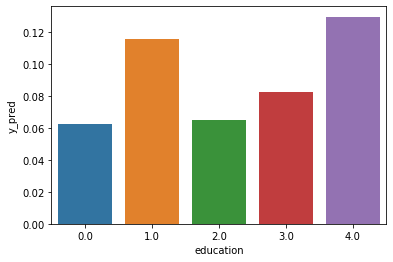

In [15]:
sns.barplot(x='education', y='y_pred', data=prob_per_education.reset_index())
plt.show()

Is your clustering solution fair? If yes, why? If not, why not?

It seems that the students are right in saying that our clustering is somehow biased by the education level. In fact, universitary users are more likely assigned to cluster 1, while all middle-school students belong to cluster 0.

# Question 4 (30 points)
To improve course quality, the CEO of LernTime decides to adapt the difficulty level of the tasks to the knowledge of the students. She asks you to develop a type of knowledge tracing model able to predict the number of points a student will get on the next problem, based on the observed performance (in terms of points) on all the past problems.
You are provided with an example data set from a mathematics course, containing the following columns: 

| Name                   | Description                         |
| ---------------------- | ------------------------------------------------------------ |
| user_id | The ID of the student who is solving the problem.  | |
| order_id | The temporal ID (timestamp) associated with the student's answer to the problem.  | |
| relative_week | The week # since the student's first interaction with the platform.   | |
| problem_id | The ID associated with the problem. | |
| score | The student's performance on the problem in terms of obtained points. The maximum number of points is 10 and the minimum number of points is 0.

You decide to use a Deep Knowledge Tracing model (with an LSTM layer). Unfortunately, you cannot directly use a standard DKT architecture as:

1. Your data does not have skill names or IDs available, so you will have to modify DKT to predict based on problem IDs.

2. Instead of predicting a binary outcome (right/wrong), your goal is to predict the number of obtained points (score).

Your tasks therefore are to:

a) Implement and evaluate an adjusted version of a DKT model able to predict the number of points a student will obtain on a problem.

b) Justify and discuss all your design choices.

In [62]:
student_df = pd.read_csv('data/lerntime_kt.csv')
student_df

,user_id,order_id,relative_week,problem_id,score
0,94400,163987467,0,6473,10.0
1,94400,164499411,5,11893,10.0
2,94987,172053491,0,37570,10.0
3,94987,172092447,0,7195,10.0
4,94987,172243850,2,5945,10.0
...,...,...,...,...,...
31653,361511,175196995,1,164496,10.0
31654,361770,175148600,0,37570,6.5
31655,361770,175280418,1,39162,0.0
31656,361771,175138828,0,39162,10.0


### a) Implementation of (adjusted) DKT model (20 points)

Fortunately, you already have code available (below) for properly training and evaluating a standard DKT model. **Modify** this code to be able to predict the number of points a student will get on the next problem, based on the observed performance (in terms of points) on all the past problems. Note that the code in its current format **will not run properly** due to the two differences mentioned above: the data set at hand does not have skill names available and your model needs to predict the total number of obtained points for a problem instead of a binary outcome.

Train your model for 10 epochs, and use the best model callback to find the optimal model. Evaluate your model using **appropriate performance metric(s)** - please print your metric(s). You do not need to tune the hyperparameters of your model for this task; instead use the following settings (already provided in the code below):

```
params['batch_size'] = 32
params['mask_value'] = -1.0
params['verbose'] = 1
params['best_model_weights'] = 'weights/bestmodel' 
params['optimizer'] = 'adam'
params['recurrent_units'] = 32
params['epochs'] = 10
params['dropout_rate'] = 0.1
```

In [17]:
# MODIFY THE CODE BELOW TO ADJUST THE DKT IMPLEMENTATION

In [63]:
# Function for splitting the data into a training and test set
def create_iterator(data):
    '''
    Create an iterator to split interactions in data into train and test, with the same student not appearing in two diverse folds.
    :param data:        Dataframe with student's interactions.
    :return:            An iterator.
    '''    
    # Both passing a matrix with the raw data or just an array of indexes works
    X = np.arange(len(data.index))
    # Groups of interactions are identified by the user id (we do not want the same user appearing in two folds)
    groups = data['user_id'].values 
    return model_selection.GroupShuffleSplit(n_splits=1, train_size=.8, test_size=0.2, random_state=0).split(X, groups=groups)

In [64]:
# Hyperparameters are fixed!
params = {}
params['batch_size'] = 32
params['mask_value'] = -1.0
params['verbose'] = 1
params['best_model_weights'] = 'weights/bestmodel' 
params['optimizer'] = 'adam'
params['recurrent_units'] = 32
params['epochs'] = 10
params['dropout_rate'] = 0.1

In [70]:
# Functions for building the Tensorflow input sequences for the model
def prepare_seq(df):
    '''
    Extract user_id sequence in preparation for DKT. The output of this function 
    feeds into the prepare_data() function. 
    '''
    # Enumerate problem id as a categorical variable 
    # (i.e. [32, 12, 32, 45] -> [0, 1, 0, 2])
    df['skill'], skill_codes = pd.factorize(df['problem_id'], sort=True)

    # Cross skill id with answer to form a synthetic feature
    df['skill_with_answer'] = df['skill'] * 2 + df['score']

    # Convert to a sequence per user_id and shift features 1 timestep
    seq = df.groupby('user_id').apply(lambda r: (r['skill_with_answer'].values[:-1], r['skill'].values[1:], r['score'].values[1:],))
    
    # Get max skill depth and max feature depth
    skill_depth = df['skill'].max() 
    features_depth = df['skill_with_answer'].max() + 1

    return seq, int(features_depth), int(skill_depth)

def prepare_data(seq, params, features_depth, skill_depth):
    '''
    Manipulate the data sequences into the right format for DKT with padding by batch
    and encoding categorical features.
    '''
    
    # Get Tensorflow Dataset
    dataset = tf.data.Dataset.from_generator(generator=lambda: seq, output_types=(tf.int32, tf.int32, tf.float32))

    # Encode categorical features and merge skills with labels to compute target loss
    dataset = dataset.map(
        lambda feat, skill, label: (
            tf.one_hot(feat, depth=features_depth),
            tf.concat(values=[tf.one_hot(skill, depth=skill_depth), tf.expand_dims(label, -1)], axis=-1)
        )
    )

    # Pad sequences to the appropriate length per batch
    dataset = dataset.padded_batch(
        batch_size=params['batch_size'],
        padding_values=(params['mask_value'], params['mask_value']),
        padded_shapes=([None, None], [None, None]),
        drop_remainder=True
    )

    return dataset.repeat(), len(seq)


In [71]:
# Function for getting the Tensorflow output sequences for the model
def get_target(y_true, y_pred, mask_value=params['mask_value']):
    ''' 
    Adjust y_true and y_pred to ignore predictions made using padded values.
    '''
    # Get skills and labels from y_true
    mask = 1. - tf.cast(tf.equal(y_true, mask_value), y_true.dtype)
    y_true = y_true * mask

    problems, y_true = tf.split(y_true, num_or_size_splits=[-1, 1], axis=-1)

    # Get predictions for each skill
    y_pred = tf.reduce_sum(y_pred * problems, axis=-1, keepdims=True)

    return y_true, y_pred

In [72]:
# Obtain indexes for training and test sets
train_index, test_index = next(create_iterator(student_df))

# Split the data into training and test
X_train, X_test = student_df.iloc[train_index], student_df.iloc[test_index]

# Obtain indexes for training and validation sets
train_val_index, val_index = next(create_iterator(X_train))

# Split the training data into training and validation
X_train_val, X_val = X_train.iloc[train_val_index], X_train.iloc[val_index]

In [76]:
student_df[student_df.user_id == 94400]

,user_id,order_id,relative_week,problem_id,score,skill,skill_with_answer
0,94400,163987467,0,6473,10.0,15,40.0
1,94400,164499411,5,11893,10.0,70,150.0


In [81]:
student_df[(student_df.skill_with_answer == 40) & (student_df.skill != 15)]

,user_id,order_id,relative_week,problem_id,score,skill,skill_with_answer
21407,329470,170566632,0,6913,0.0,20,40.0


In [92]:
student_df.score.unique()

array([10. ,  0. ,  3.5,  6.5,  8. ,  2. ])

In [90]:
aybars_df = student_df.groupby('skill_with_answer').apply(lambda x: set(x.skill) if len(set(x.skill)) > 1 else None).dropna().reset_index()
aybars_df

,skill_with_answer,0
0,10.0,"{0, 5}"
1,12.0,"{1, 6}"
2,14.0,"{2, 7}"
3,16.0,"{8, 3}"
4,18.0,"{9, 4}"
...,...,...
84,190.0,"{90, 95}"
85,192.0,"{96, 91}"
86,194.0,"{97, 92}"
87,196.0,"{98, 93}"


In [75]:
seq

user_id
94400                       ([40.0], [70], [10.0])
94987       ([194.0, 96.0], [43, 2], [10.0, 10.0])
95610     ([130.0, 200.0], [95, 59], [10.0, 10.0])
96409        ([94.0, 12.0], [1, 63], [10.0, 10.0])
118571                      ([38.0], [73], [10.0])
                            ...                   
361379    ([122.0, 110.0], [50, 51], [10.0, 10.0])
361510                     ([202.0], [97], [10.0])
361511                     ([202.0], [97], [10.0])
361770                      ([190.5], [95], [0.0])
361771                      ([200.0], [21], [0.0])
Length: 5869, dtype: object

In [74]:
# Build TensorFlow sequence datasets for training, validation, and test data
seq, features_depth, problems_depth = prepare_seq(student_df)
seq_train = seq[X_train_val.user_id.unique()]
seq_val = seq[X_val.user_id.unique()]
seq_test = seq[X_test.user_id.unique()]

# Prepare the training, validation, and test data in the DKT input format
tf_train, length = prepare_data(seq_train, params, features_depth, problems_depth)
tf_val, val_length  = prepare_data(seq_val, params, features_depth, problems_depth)
tf_test, test_length = prepare_data(seq_test, params, features_depth, problems_depth)

# Calculate the length of each of the train-test-val sets and store as parameters
params['train_size'] = int(length // params['batch_size'])
params['val_size'] = int(val_length // params['batch_size'])
params['test_size'] = int(test_length // params['batch_size'])

In [69]:
# Custom metrics for training and testing
class RMSE(tf.keras.metrics.RootMeanSquaredError):
    # Our custom RMSE calls our get_target function first to remove predictions on padded values, 
    # then computes a standard RMSE metric.
    def update_state(self, y_true, y_pred, sample_weight=None):
        true, pred = get_target(y_true, y_pred)
        super(RMSE, self).update_state(y_true=true, y_pred=pred, sample_weight=sample_weight)

mse = tf.keras.losses.MeanSquaredError()
def CustomMeanSquaredError(y_true, y_pred): 
    # Our custom mean squared error loss calls our get_target function first 
    # to remove predictions on padded values, then computes standard binary cross-entropy.
    y_true, y_pred = get_target(y_true, y_pred)
    return mse(y_true, y_pred)  

In [25]:
# Function for creating the model itself
def create_model_lstm(nb_features, nb_skills, params):
    
    # Create an LSTM model architecture
    inputs = tf.keras.Input(shape=(None, nb_features), name='inputs')

    # We use a masking layer here to ignore our masked padding values
    x = tf.keras.layers.Masking(mask_value=params['mask_value'])(inputs)

    # This LSTM layer is the crux of the model; we use our parameters to specify
    # what this layer should look like (# of recurrent_units, fraction of dropout).
    x = tf.keras.layers.LSTM(params['recurrent_units'], return_sequences=True, dropout=params['dropout_rate'])(x)
    
    # We use a dense layer with the sigmoid function activation to map our predictions 
    # between 0 and 1.
    dense = tf.keras.layers.Dense(nb_skills, activation='sigmoid')

    # The TimeDistributed layer takes the dense layer predictions and applies the sigmoid 
    # activation function to all time steps.
    outputs = tf.keras.layers.TimeDistributed(dense, name='outputs')(x)
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs, name='DKT')

    # Compile the model with our loss functions, optimizer, and metrics.
    model.compile(loss=CustomMeanSquaredError, 
                  optimizer=params['optimizer'], 
                  metrics=[RMSE()])
    
    return model

# Create our DKT model using an LSTM
dkt_lstm = create_model_lstm(int(features_depth), problems_depth, params)
dkt_lstm.summary()

Model: "DKT"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, None, 209)]       0         
                                                                 
 masking (Masking)           (None, None, 209)         0         
                                                                 
 lstm (LSTM)                 (None, None, 32)          30976     
                                                                 
 outputs (TimeDistributed)   (None, None, 99)          3267      
                                                                 
Total params: 34,243
Trainable params: 34,243
Non-trainable params: 0
_________________________________________________________________


In [26]:
# This line tells our training procedure to only save the best version of the model at any given time.
ckp_callback = tf.keras.callbacks.ModelCheckpoint(params['best_model_weights'], 
                                                  save_best_only=True, save_weights_only=True)

# Let's fit our LSTM model on the training data. This cell takes 8 minutes to run on Colab.
history = dkt_lstm.fit(tf_train, epochs=params['epochs'], steps_per_epoch=params['train_size']-1, 
                       validation_data=tf_val, validation_steps=params['val_size'],
                       callbacks=[ckp_callback], verbose=params['verbose'])

Epoch 1/10


2022-07-04 11:32:53.480664: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


116/116 [==============================] - 3s 15ms/step - loss: 13.5151 - root_mean_squared_error: 9.1883 - val_loss: 8.6320 - val_root_mean_squared_error: 9.0870
Epoch 2/10
116/116 [==============================] - 1s 10ms/step - loss: 13.0298 - root_mean_squared_error: 8.9982 - val_loss: 8.2143 - val_root_mean_squared_error: 8.8622
Epoch 3/10
116/116 [==============================] - 1s 10ms/step - loss: 12.5489 - root_mean_squared_error: 8.8652 - val_loss: 8.0855 - val_root_mean_squared_error: 8.7971
Epoch 4/10
116/116 [==============================] - 1s 11ms/step - loss: 12.4692 - root_mean_squared_error: 8.8225 - val_loss: 8.0222 - val_root_mean_squared_error: 8.7651
Epoch 5/10
116/116 [==============================] - 1s 12ms/step - loss: 12.3849 - root_mean_squared_error: 8.7920 - val_loss: 7.9839 - val_root_mean_squared_error: 8.7457
Epoch 6/10
116/116 [==============================] - 1s 10ms/step - loss: 12.3920 - root_mean_squared_error: 8.7752 - val_loss: 7.9568 - val

In [27]:
# We load the LSTM model with the best performance, and evaluate it on the test set. 
dkt_lstm.load_weights(params['best_model_weights'])
dkt_lstm.evaluate(tf_test, steps=params['test_size'], verbose=params['verbose'], return_dict=True)

36/36 [==============================] - 0s 3ms/step - loss: 8.5144 - root_mean_squared_error: 8.7423


{'loss': 8.514423370361328, 'root_mean_squared_error': 8.742298126220703}

### b) Justification of design choices (10 points)

In your model architecture, how did you construct your model inputs and outputs? Why did you design it this way?

Instead of skills, as in the course, we use here analogously the problem IDs, encoding it in a one-hot vector. However, since we now care about the score instead of a correct/wrong label, we are now dealing with a regression problem instead of classification. Therefore, we cannot use for inputs a one-hot representation of the tuple (problem_id, label) and we rely instead on a representation similar to the target's one, i.e. concatenating the one-hot encoded vector of problem_ids and the score value.

The model outputs a predicted score for each of the problems, which then is recasted in get_target so to consider only non-masked values corresponding to the relevant problem. Since we frame the problem as a regression one, the score can be any value between 0 and 10. To enforce the limits, we predict an output using sigmoid, and then rescale it multiplying it by 10. Again, being an instance of regression, we train the model using a custom implementation of the Mean Squared Error.

To measure model performance we use RMSE, which stems naturally from the regression framing of the problem and is very linked to the loss we used to optimize the model (MSE). 

# Question 5 (30 points)
The CEO of LernTime decides to further improve the quality of the platform. Specifically, she would like to support struggling students early on by offering them targeted interventions and to also provide advanced tasks to excellent students. She asks you to develop a model that is able to identify the very high and very low performers **early on**, i.e. after the **first 6 weeks** of their interactions with a course. For all courses, advanced tasks should be offered to the top 20% of students, while the bottom 20% of students should benefit from interventions. The overall performance of a student at the end of the course is determined by the final exam score at the end of the course, from 0 to 100 in `exam_score`.

Using the dataframe `aggregated_student_df` from the already familiar mathematics course, your data scientist colleagues have already divided the students into three groups based on the procedure described above:

1. intervene: students who need help (`exam_score` <= 46.5)
2. on-track: students who are on track (`exam_score` > 46.7 and `exam_score` <= 70.5)
3. advanced: exceptional students (`exam_score` > 70.5)

They provide you the information about the clusters in the `group` column in the `aggregated_student_df` dataframe, as well as the `exam_score` each student obtained at the end of the course.

Your tasks are to:

a) Implement and evaluate a model (using an LSTM layer) able to predict the *group* (intervene, on-track, advanced) of a student based on his/her performance during the first six weeks (total points on problems obtained each week: `week_0`, `week_1`,  ... `week_5`).

b) Visualize and discuss the performance of your model.

In [95]:
# Dataframe with group labels, aggregated from the original student_df.
# The scores for week_0 through week_5 are the aggregated (summed) points of all 
# the problems the student answered that week.

aggregated_student_df = pd.read_csv('data/lerntime_classification.csv')
aggregated_student_df

,user_id,week_0,week_1,week_2,week_3,week_4,week_5,group,exam_score
0,94400,10.0,0.0,0.0,0.0,0.0,10.0,intervene,34.0
1,94987,20.0,0.0,10.0,0.0,0.0,0.0,on-track,63.5
2,95610,20.0,10.0,0.0,0.0,0.0,0.0,advanced,71.0
3,96409,10.0,0.0,0.0,0.0,0.0,20.0,on-track,63.5
4,118571,10.0,0.0,0.0,0.0,0.0,10.0,on-track,51.0
...,...,...,...,...,...,...,...,...,...
5864,361379,10.0,0.0,20.0,0.0,0.0,0.0,on-track,63.5
5865,361510,10.0,10.0,0.0,0.0,0.0,0.0,on-track,51.0
5866,361511,10.0,10.0,0.0,0.0,0.0,0.0,on-track,60.5
5867,361770,6.5,0.0,0.0,0.0,0.0,0.0,intervene,38.5


### a) Implementation of performance prediction model (20 points)
Create an a time-series model (using an LSTM layer), able to predict the `group` of a student based on the interactions of the first six weeks. Train your model for 10 epochs, and use the best model callback to find the optimal model. Evaluate your model using an appropriate performance metric (simply print it). Again do not need to tune the hyperparameters of your model for this task; instead use the following settings:

```params['batch_size'] = 32
params['mask_value'] = -1.0
params['verbose'] = 1
params['best_model_weights'] = 'weights/bestmodel' 
params['optimizer'] = 'adam'
params['recurrent_units'] = 32
params['epochs'] = 10
params['dropout_rate'] = 0.1
```

Luckily, one of your colleagues has already implemented a skeleton for the model and therefore, you only need to add your code to this skeleton.

In [113]:
# Build df_x (the input data) and  df_y (the labels)
nb_weeks = 6
nb_groups = 3

# df_x should become a NumPy array of size num_of_students * num_weeks * num_of_features.
df_x = aggregated_student_df[['week_0','week_1', 'week_2', 'week_3', 'week_4', 'week_5']].values
df_x = df_x.reshape(len(df_x), 1, nb_weeks)

# preprocess labels
df_y = aggregated_student_df['group'].replace({'intervene': 0, 'on-track': 1, 'advanced': 2}).values.reshape(-1, 1)
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(df_y)
df_y = enc.transform(df_y).toarray()

In [114]:
# Split the data into training and test set
df_x_train, df_x_test, df_y_train, df_y_test = train_test_split(df_x, 
                                                                df_y,
                                                                test_size=0.2, 
                                                                random_state=0, 
                                                                stratify=df_y)

# Split the training data further into training and validation sets.
df_x_train_val, df_x_val, df_y_train_val, df_y_val = train_test_split(df_x_train, 
                                                                      df_y_train, 
                                                                      test_size=0.2,
                                                                      random_state=0, 
                                                                      stratify=df_y_train)

In [121]:
df_x_train.shape

(4695, 1, 6)

In [122]:
# Hyperparameters are fixed!
params = {}
params['mask_value'] = -1.0
params['verbose'] = 1
params['best_model_weights'] = 'weights/bestmodel' 
params['optimizer'] = 'adam'
params['recurrent_units'] = 32
params['epochs'] = 10
params['dropout_rate'] = 0.1

In [123]:
# Create the LSTM time-series model (use one LSTM layer)
def create_model_lstm_time_series(nb_weeks, nb_groups, params):
    
    # Create an LSTM model architecture.
    inputs = tf.keras.Input(shape=(None, nb_weeks), name='inputs')
    
    # We use a masking layer here to ignore our masked padding values
    x = tf.keras.layers.Masking(mask_value=params['mask_value'])(inputs)

    # This LSTM layer is the crux of the model; we use our parameters to specify
    # what this layer should look like (# of recurrent_units, fraction of dropout).
    # Note that return_sequences=False because we want a many-to-one architecture.
    x = tf.keras.layers.LSTM(params['recurrent_units'], 
                             return_sequences=False, 
                             dropout=params['dropout_rate'])(x)
    
        
    dense = tf.keras.layers.Dense(nb_groups, activation='softmax')
    outputs = dense(x)
    print(outputs.shape)
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs, name='TimeSeries')

    # Compile the model with our loss functions, optimizer, and metrics.
    model.compile(loss=tf.keras.losses.binary_crossentropy, 
                  optimizer=params['optimizer'],
                  metrics=[tf.keras.metrics.AUC(), 'binary_accuracy'])    
    return model

time_series_lstm = create_model_lstm_time_series(nb_weeks, nb_groups, params)

(None, 3)


In [124]:
# We save only the best model during the training process.
ckp_callback = tf.keras.callbacks.ModelCheckpoint(params['best_model_weights'], 
                                                  save_best_only=True, save_weights_only=True)

# Fit the DKT LSTM model on the given data set.
history = time_series_lstm.fit(df_x_train_val, 
                               df_y_train_val, 
                               epochs=params['epochs'],
                               validation_data=(df_x_val, df_y_val),
                               callbacks=[ckp_callback], 
                               verbose=params['verbose'])

Epoch 1/10


118/118 [==============================] - 5s 31ms/step - loss: 0.6180 - auc_8: 0.6717 - binary_accuracy: 0.6932 - val_loss: 0.5679 - val_auc_8: 0.7202 - val_binary_accuracy: 0.7213
Epoch 2/10
118/118 [==============================] - 3s 21ms/step - loss: 0.5593 - auc_8: 0.7342 - binary_accuracy: 0.7209 - val_loss: 0.5486 - val_auc_8: 0.7608 - val_binary_accuracy: 0.7245
Epoch 3/10
118/118 [==============================] - 2s 21ms/step - loss: 0.5423 - auc_8: 0.7689 - binary_accuracy: 0.7229 - val_loss: 0.5321 - val_auc_8: 0.7818 - val_binary_accuracy: 0.7270
Epoch 4/10
118/118 [==============================] - 2s 21ms/step - loss: 0.5262 - auc_8: 0.7848 - binary_accuracy: 0.7267 - val_loss: 0.5164 - val_auc_8: 0.7943 - val_binary_accuracy: 0.7306
Epoch 5/10
118/118 [==============================] - 2s 21ms/step - loss: 0.5129 - auc_8: 0.7953 - binary_accuracy: 0.7326 - val_loss: 0.5050 - val_auc_8: 0.8009 - val_binary_accuracy: 0.7409
Epoch 6/10
118/118 [==========================

In [125]:
# Load the best version of the the trained model and compute its prediction
time_series_lstm.load_weights(params['best_model_weights'])
predictions = time_series_lstm.predict(df_x_test)

37/37 [==============================] - 1s 10ms/step


In [126]:
# Use an appropriate error metric to evaluate the performance of your model and print the error metric
auc = roc_auc_score(df_y_test,predictions)
print("AUC: ", auc)

AUC:  0.7410870945853052


### b) Visualization and discussion (10 points)
How well does your model perform? Provide a visualization to support your argument.

In [127]:
predictions_coded = predictions.argmax(axis=1)
df_y_test_coded = df_y_test.argmax(axis=1)

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix(df_y_test_coded, predictions_coded), display_labels=['intervene', 'on-track', 'advanced'])
disp.plot()
plt.show()

The model is performing reasonably well on AUC, predicting the correct label 73.7% of the time. However, we note that our model never predicts that we should intervene, which is a big problem. The model has a large bias to predicting students are on track, missing 243 students we should have intervened on as predicted on-track students. 

It misses more than half of the truly advanced students, predicting that 136 students are on-track when they should be advanced, but manages to correctly predict 110 students are advanced. 

Overall, our model is good at predicting students are on-track, getting it wrong only 10% of the time. However, it completely fails at predicting students need help, and only manages to get 44.7% of students that are advanced correctly predicted in the advanced category.